In [79]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
from IPython.core.magic import register_cell_magic
from IPython.core.magic import (Magics, magics_class, line_magic,
                                cell_magic, line_cell_magic)
from IPython.display import clear_output, display, HTML
import ipywidgets as widgets

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import re

class WardleyMap():

    # Developed using https://regex101.com/
    _coords_regexs = "\[\s*([\d\.-]+)\s*,\s*([\d\.-]+)\s*\]"
    _node_regex = re.compile(r"^(\w+) ([\w ]+)\s+{COORDS}(\s+label\s+{COORDS})*".format(COORDS=_coords_regexs))
    _evolve_regex = re.compile(r"^evolve ([\w ]+)\s+([\d\.-]+)(\s+label\s+{COORDS})*".format(COORDS=_coords_regexs))

    def __init__(self, owm):
        # Defaults:
        self.title = None
        self.nodes = {}
        self.edges = []
        self.evolutions = {}
        self.annotations = []
        self.annotation = {}
        self.notes = []
        self.style = None
        self.warnings = []

        # And load:
        for cl in owm.splitlines():
            cl = cl.strip()
            if not cl:
                continue
            if cl.startswith('title '):
                self.title = cl.split(' ', maxsplit=1)[1]
            elif cl.startswith('style '):
                self.style = cl.split(' ', maxsplit=1)[1]
            elif cl.startswith('anchor ') or cl.startswith('component '):
                # Use RegEx to split into fields:
                match = self._node_regex.search(cl)
                if match != None:
                    matches = match.groups()
                    node = {
                        'type' : matches[0],
                        'title': matches[1],
                        'vis' : float(matches[2]),
                        'mat' : float(matches[3])
                    }
                    # Handle label position adjustments:
                    if matches[4]:
                        node['label_x'] = float(matches[5])
                        node['label_y'] = float(matches[6])
                    else:
                        # Default to a small additional offset:
                        node['label_x'] = 2
                        node['label_y'] = 2
                    # And store it:
                    self.nodes[node['title']] = node
                else:
                    self.warnings.append("Could not parse component line: %s" % cl)
            elif "->" in cl:
                n_from, n_to = cl.split('->')
                self.edges.append([n_from.strip(), n_to.strip()])
            elif cl.startswith('evolve '):
                match = self._evolve_regex.search(cl)
                if match != None:
                    matches = match.groups()
                    evol = {
                        'title' : matches[0],
                        'mat' : float(matches[1])
                    }
                    # Handle label position adjustments:
                    if matches[2]:
                        evol['label_x'] = float(matches[3])
                        evol['label_y'] = float(matches[4])
                    else:
                        # Default to a small additional offset:
                        evol['label_x'] = 2
                        evol['label_y'] = 2
                    # And store it:
                    self.evolutions[matches[0]] = evol
                else:
                    self.warnings.append("Could not parse evolution line: %s" % cl)
            elif cl.startswith('#'):
                # Skip comments...
                pass
            else:
                # Warn about lines we can't handle?
                self.warnings.append("Could not parse line: %s" % cl)

@magics_class
class WardleyMagics(Magics):

    @line_magic
    def lmagic(self, line):
        "my line magic"
        print("Full access to the main IPython object:", self.shell)
        print("Variables in the user namespace:", list(self.shell.user_ns.keys()))
        return line

    @cell_magic
    def cmagic(self, line, cell):
        "my cell magic"
        return line, cell

    @line_cell_magic
    def lcmagic(self, line, cell=None):
        "Magic that works both as %lcmagic and as %%lcmagic"
        if cell is None:
            print("Called as line magic")
            return line
        else:
            print("Called as cell magic")
            return line, cell

    @cell_magic
    def wardley(self, line, cell):
        "Wardley mapping"

        # Clear output:
        clear_output()

        # Parse the OWM syntax:
        wm = WardleyMap(cell)

        # Now plot, with styles:
        fig = None
        figsize = (12,8)
        if wm.style == 'wardley':
            # Set up the default plot:
            fig, ax = plt.subplots(figsize=figsize)
            # Add the gradient background
            norm = matplotlib.colors.Normalize(0,1)
            colors = [[norm(0.0), "white"], [norm(0.5), "white"], [norm(1.0), "#f6f6f6"]]
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
            plotlim = plt.xlim() + plt.ylim()
            ax.imshow([[1,0,1],[1,0,1]], cmap=cmap, interpolation='bicubic', extent=plotlim, aspect='auto')
            # And plot as normal:
            self.generate_wardley_plot(ax, wm)
        elif wm.style in ['xkcd', 'handwritten']:
            with plt.xkcd(scale=0.5):
                fig, ax = plt.subplots(figsize=figsize)
                self.generate_wardley_plot(ax, wm)
        elif wm.style in ['default', 'plain']:
            fig, ax = plt.subplots(figsize=figsize)
            self.generate_wardley_plot(ax,wm)
        elif wm.style in plt.style.available:
            with plt.style.context(wm.style):
                fig, ax = plt.subplots(figsize=figsize)
                self.generate_wardley_plot(ax, wm)
        elif wm.style != None:
            self.show_warning("Map style '%s' not recognised or supported." % wm.style)

        # turn of interactive plotting mode (we hand it back to the notebook instead, so it can be handed on)
        plt.close(fig)

        return fig

    # Helper to report problems:
    def show_warning(self, message):
        display(HTML("<strong>WARNING:</strong> %s" % message))

    # Actually plot:
    def generate_wardley_plot(self, ax, wm):
        # Set up basic properties:
        if wm.title:
            plt.title(wm.title)
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # Plot the lines:
        l = []
        for edge in wm.edges:
            if edge[0] in wm.nodes and edge[1] in wm.nodes:
                n_from = wm.nodes[edge[0]]
                n_to = wm.nodes[edge[1]]
                l.append([ (n_from['mat'],n_from['vis']), (n_to['mat'],n_to['vis']) ])
            else:
                for n in edge:
                    if n not in wm.nodes:
                        show_warning("Could not find a component called '%s'!" % n)
        if len(l) > 0:
            lc = LineCollection(l, color=matplotlib.rcParams['axes.edgecolor'], lw=1)
            #lc = LineCollection(l, color="k", lw=1, linestyle=['-'])
            ax.add_collection(lc)

        # Add the nodes:
        for node_title in wm.nodes:
            n = wm.nodes[node_title]
            if n['type'] == 'component':
                #plt.plot(n['mat'], n['vis'], marker='o', color='w', markeredgecolor='k', markeredgewidth=1.0)
                plt.plot(n['mat'], n['vis'], marker='o', color=matplotlib.rcParams['axes.facecolor'], 
                    markeredgecolor=matplotlib.rcParams['axes.edgecolor'])
            ax.annotate(node_title, fontsize=10,
                xy=(n['mat'], n['vis']), xycoords='data',
                xytext=(n['label_x'], n['label_y']), textcoords='offset pixels',
                horizontalalignment='left', verticalalignment='bottom')

        plt.yticks([0.0,0.925], ['Invisible', 'Visible'], rotation=90, verticalalignment='bottom')
        plt.ylabel('Value Chain', fontweight='bold')
        plt.xticks([0.0, 0.25,0.5, 0.75], ['Genesis', 'Custom-Built', 'Product\n(+rental)', 'Commodity\n(+utility)'], ha='left')
        plt.xlabel('Evolution', fontweight='bold')

        plt.tick_params(axis='x', direction='in', top=True, bottom=True, grid_linewidth=1)
        plt.grid(b=True, axis='x', linestyle='--')
        plt.tick_params(axis='y', length=0)

        # Show warnings if problems were found:
        for message in wm.warnings:
            self.show_warning(message)
        if len(wm.evolutions) > 0:
            self.show_warning("Displaying evolutions is not implemented yet!")



# In order to actually use these magics, you must register them with a
# running IPython.

def load_ipython_extension(ipython):
    """
    Any module file that define a function named `load_ipython_extension`
    can be loaded via `%load_ext module.path` or be configured to be
    autoloaded by IPython at startup time.
    """
    # You can register the class itself without instantiating it.  IPython will
    # call the default constructor on it.
    ipython.register_magics(WardleyMagics)



In [80]:
ipython = get_ipython()
ipython.register_magics(WardleyMagics)

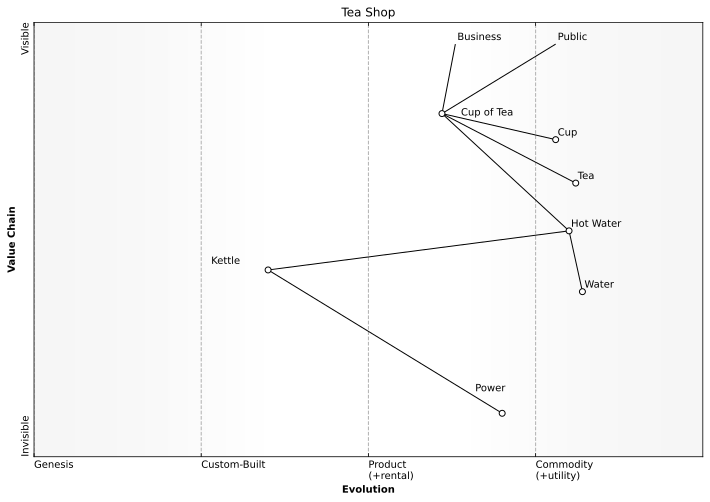

In [81]:
%%wardley
title Tea Shop
anchor Business [0.95, 0.63]
anchor Public [0.95, 0.78]
component Cup of Tea [0.79, 0.61] label [19, -4]
component Cup [0.73, 0.78]
component Tea [0.63, 0.81]
component Hot Water [0.52, 0.80]
component Water [0.38, 0.82]
component Kettle [0.43, 0.35] label [-57, 4]
component Power [0.1, 0.7] label [-27, 20]
Business->Cup of Tea
Public->Cup of Tea
Cup of Tea->Cup
Cup of Tea->Tea
Cup of Tea->Hot Water
Hot Water->Water
Hot Water->Kettle 
Kettle->Power

# Any matplotlib style should work, as well as 'wardley' and 'xkcd'/'handwritten'
style wardley

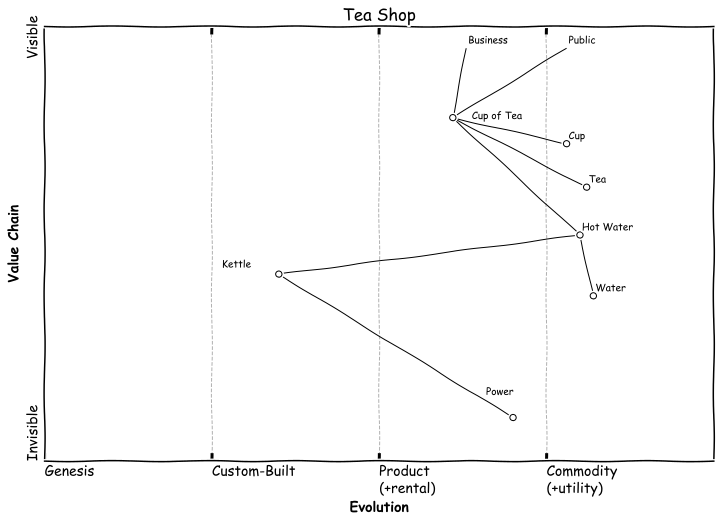

In [82]:
%%wardley test
title Tea Shop
anchor Business [0.95, 0.63]
anchor Public [0.95, 0.78]
component Cup of Tea [0.79, 0.61] label [19, -4]
component Cup [0.73, 0.78]
component Tea [0.63, 0.81]
component Hot Water [0.52, 0.80]
component Water [0.38, 0.82]
component Kettle [0.43, 0.35] label [-57, 4]
evolve Kettle 0.62 label [16, 7]
component Power [0.1, 0.7] label [-27, 20]
evolve Power 0.89 label [-12, 21]
Business->Cup of Tea
Public->Cup of Tea
Cup of Tea->Cup
Cup of Tea->Tea
Cup of Tea->Hot Water
Hot Water->Water
Hot Water->Kettle 
Kettle->Power

annotation 1 [[0.43,0.49],[0.08,0.79]] Standardising power allows Kettles to evolve faster
annotation 2 [0.48, 0.85] Hot water is obvious and well known
annotations [0.60, 0.02]

note +a generic note appeared [0.23, 0.33]

style xkcd

In [83]:
# Make previous cell output available for use in other pages:
from myst_nb import glue
glue("wardley_map_example", _, display=False)